# Graph Coloring Analysis Project

This project looks at implementing an algorithm in multiple ways to solve a problem, analyzing the
algorithms’ implementations for running time, and testing and your implementations to show they
match your analysis. The project also looks at testing to determine how well the multiple
implementations solve the problem.<br/>
The particular problem for the project is scheduling via graph coloring. For the first part of the project,
different conflict graphs which can represent real world problems will be created and saved in files. For
the second part of the problem, various coloring orders will be implemented and analyzed for runtime
efficiency and coloring efficiency. These efficiencies are intimately related to the data structures used
for both the input graph data and the intermediate data necessary for the ordering and coloring
algorithms.

## Part 1

### Purpose

Part 1 of the project is used to create different conflict graphs. Conflict graphs represent realworld problems. For example, one may be thought of as a set of vertices representing courses that students may take. An edge is present between two vertices (courses) in the graph if a student is taking both courses. This edge indicates they may not be scheduled at the same time.<br/>
Once the graph is colored, the color of each vertex represents its timeslot and the total number of colors would represent the total number of required timeslots for that coloring.<br/>
The vertices which have a conflict in this project will be determined based on graph types and a random number generator with different distributions.

In [81]:
# Imports
import numpy as np
from scipy.stats import skew
import random
import matplotlib.pyplot as plt
import networkx as nx
import copy
import time
import pandas as pd

### Helper Functions - Part 1

In [2]:
def write_file(adj, path="graph.txt"):
    '''
    Writes the adjacency list to a file in the format:
        N - Number of vertices in the graph with V vertices and E edges. 
        P[] = Pointer for each vertex V, 1 <= V <= N denoting the starting point in E[] of the list of 
            vertices adjacent to vertex V. That is, the vertices adjacent to vertex V are indicated in 
            locations E[P[V]], E[P[V]+1], ..., E[P[V+1]-1].  
        E[] = list of distinct graph edges (length = 2E) 

    Parameters
    ----------
    adj: list of lists (int)
        Adjacency list representing the graph 
    '''
    
    file = open(path, "w")

    # Print Number of Vertices
    file.write(str(len(adj)) + '\n')

    # Print Starting Locations of Vertices' Edges
    prevLoc = len(adj) + 1
    file.write(str(prevLoc) + '\n')
    
    for v in range(len(adj)):
        if v != 0:
            prevLoc = prevLoc + np.count_nonzero(adj[v-1]) - 1
            file.write(str(prevLoc) + '\n')


    # Print All Edges
    for v in range(len(adj)):
        for e in range(len(adj[v])):
            if e != 0:
                file.write(str(adj[v][e]) + '\n')

    file.close()

In [3]:
def print_graph_int(adj):
    '''
    Prints the graph in a picture using the library networkx
    
    Parameters
    ----------
    adj: list of lists (Vertex objects or int)
        Adjacency list representing the graph
    '''
    G = nx.Graph()
    
    # Check if it is Vertex objects or int
    if type(adj[0][0]) == int:
        i = True
    else:
        i = False
    
    # Get total number of vertices
    v_num = len(adj)
    
    # Add Vertices to graph
    G.add_nodes_from(range(1, v_num+1))
    
    # Add edges (from adjacency list) to graph
    for v in range(len(adj)):
        for e in range(len(adj[v])):
            if e != 0:
                if i:
                    G.add_edge(adj[v][0].id, adj[v][e].id)
                else:
                    G.add_edge(adj[v][0].id, adj[v][e].id)
    
    # Print the graph
    nx.draw(G, with_labels=True, font_weight='bold')

In [4]:
def fill_vertices(adj):
    '''
    Creates an adjacency list of Vertex objects from an adjacency list of ints.
    
    Parameters
    ----------
    adj: list of lists (ints)
        Adjacency list representing the graph
    
    Returns
    -------
    l: list of lists (of Vertex objects)
        Adjacency list representing the graph
    '''
    
    l = [[] for i in range(len(adj))]
    
    for i in range(len(adj)):
        # Add Vertex to first row
        l[i].append(Vertex(adj[i][0], (i, 0), len(adj[i])-1))
        
        for j in range(len(adj[i])):
            if j != 0:
                # Get the degree of that Vertex
                degree = len(adj[adj[i][j]-1]) - 1
                # Append other Vertices to the adjacency list of the Vertex at the 0th index
                l[i].append(Vertex(adj[i][j], (i, j), degree))
    
    return l

### Graph Generation Functions

In [5]:
def complete(V):
    '''
    Creates a complete graph with V vertices.

    Parameters
    ----------
    V: int
        The number of vertices

    Returns
    -------
    adj: list of lists (int)
        Adjacency list representing the graph
    '''
    # Create Adjacency List
    adj = [[0 for i in range(V)] for j in range(V)]

    # Fill in vertices at the first column in all rows
    for index in range(V):
        adj[index][0] = index + 1

    index = 0
    found = False

    for r in range(len(adj)):
        found = False
        for c in range(len(adj[r])):
            # Skip over first column
            if c == 0:
                index = adj[r][c]

            # Iterate V-1 times, fill other spots with all values except index
            else:          
                # Check if the current edge is the same as the vertex
                if c == index:
                    found = True

                # If it has found the vertex, then just skip it and all next values
                # will be + 1
                if found:
                    adj[r][c] = c + 1
                else:
                    adj[r][c] = c

    return adj

In [6]:
def cycle(V):
    '''
    Creates a cycle graph with V vertices.
    
    Parameters
    ----------
    V: int
        The number of vertices

    Returns
    -------
    adj: list of lists (int)
        Adjacency list representing the graph    
    '''
    adj = [[0 for i in range(3)] for j in range(V)]

    for index in range(V):
        adj[index][0] = index + 1
    
    for r in range(len(adj)):
        # Each vertex only has 2 edges in a cycle
        # These edges are either + or - 1 in relation to the value of the vertex
        adj[r][1] = adj[r][0] - 1
        adj[r][2] = adj[r][0] + 1

        # Check if the value is not 0 or over the number of vertices
        if adj[r][1] == 0:
            adj[r][1] = V
        
        if adj[r][2] == V+1:
            adj[r][2] = 1
    
    return adj

In [7]:
def uniform_dist(V, E, show_graph=False):
    '''
    Creates a graph with random edges with uniform distribution.
    
    Parameters
    ----------
    V: int
        The number of vertices
    E: int
        The number of edges
    show_graph: bool
        Optional parameter to show graph of edges to check the distrubition

    Returns
    -------
    adj: list of lists (int)
        Adjacency list representing the graph  
    '''
    
    # Check if the number of edges asked is greater than the maximum possible
    if ((V*(V-1))/2) < E:
        return complete(V)
    
    # Pick random vertices
    # Get a larger number of vertices to account for repeated edges or self loops
    edges = np.random.randint(1, V+1, E*10)
    
    # Fill in adjacency list with empty lists
    adj = [[j+1] for j in range(V)]
    
    counter = 0
    for i in range(len(edges)):
        # Stop when the number of edges is reached
        if counter == E:
            break
        # Pick current index and next, therefore skip every other index
        if i % 2 == 0:
            # Check if values are not the same
            if edges[i] != edges[i+1]:
                # Check for loop (if vertex will connect to itself)
                if adj[edges[i]-1][0] != edges[i+1]:
                    # Check if the edge is already in the adjacency list
                    if edges[i+1] not in adj[edges[i]-1]:
                        adj[edges[i]-1].append(edges[i+1])
                        adj[edges[i+1]-1].append(edges[i])
                        counter+=1
    
    if show_graph:
        plt.hist(edges, bins=50)
        plt.show()
    
    return adj

In [8]:
def skewed_dist(V, E, show_graph=False, debug=False):
    '''
    Creates a graph with random edges with left skewed distribution.
    
    Parameters
    ----------
    V: int
        The number of vertices
    E: int
        The number of edges
    show_graph: bool
        Optional parameter to show graph of edges to check the distrubition

    Returns
    -------
    adj: list of lists (int)
        Adjacency list representing the graph      
    '''
    
    # Check if the number of edges asked is greater than the maximum possible
    if ((V*(V-1))/2) < E:
        return complete(V)
    
    # Pick random vertices
    # Get a larger number of vertices to account for repeated edges or self loops
    edges = np.random.triangular(1, 1, V+1, E*10)
    
    edges = [int(x) for x in edges]
    
    # Fill in adjacency list with empty lists
    adj = [[j+1] for j in range(V)]
    
    counter = 0
    for i in range(len(edges)):
        # Stop when the number of edges is reached
        if counter == E:
            break
        # Pick current index and next, therefore skip every other index
        if i % 2 == 0:
            # Check if values are not the same
            if edges[i] != edges[i+1]:
                # Check for loop (if vertex will connect to itself)
                if adj[edges[i]-1][0] != edges[i+1]:
                    # Check if the edge is already in the adjacency list
                    if edges[i+1] not in adj[edges[i]-1]:
                        adj[edges[i]-1].append(edges[i+1])
                        adj[edges[i+1]-1].append(edges[i])
                        counter+=1
    
    if show_graph:
        plt.hist(edges, bins=50)
        plt.show()
    
    return adj

In [9]:
def binomial_dist(V, E, show_graph=False):
    '''
    Creates a graph with random edges with left binomial distribution.
    
    Parameters
    ----------
    V: int
        The number of vertices
    E: int
        The number of edges
    show_graph: bool
        Optional parameter to show graph of edges to check the distrubition

    Returns
    -------
    adj: list of lists (int)
        Adjacency list representing the graph      
    '''
    
    # Check if the number of edges asked is greater than the maximum possible
    if ((V*(V-1))/2) < E:
        return complete(V)
    
    # Pick random vertices
    # Get a larger number of vertices to account for repeated edges or self loops
    edges = [np.random.binomial(V, 0.5) for i in range(E*10)]
    edges = list(filter((0).__ne__, edges))
    
    edges = [int(x) for x in edges]
    
    # Fill in adjacency list with empty lists
    adj = [[j+1] for j in range(V)]
    
    counter = 0
    for i in range(len(edges)):
        # Stop when the number of edges is reached
        if counter == E:
            break
        # Pick current index and next, therefore skip every other index
        if i % 2 == 0:
            # Check if values are not the same
            if edges[i] != edges[i+1]:
                # Check for loop (if vertex will connect to itself)
                if adj[edges[i]-1][0] != edges[i+1]:
                    # Check if the edge is already in the adjacency list
                    if edges[i+1] not in adj[edges[i]-1]:
                        adj[edges[i]-1].append(edges[i+1])
                        adj[edges[i+1]-1].append(edges[i])
                        counter+=1
    
    if show_graph:
        plt.hist(edges, bins=5000000000)
        plt.show()
    
    return adj

### Testing Max Cases for Graph Generation

The following code snippets are here to test how well the graph generation algorithms perform to create the maximum graph possible on this assignment. Although the random distribution graphs take longer, they do not take more than 3 minutes each to finish. Therefore, they can run on a reasonable amount of time.

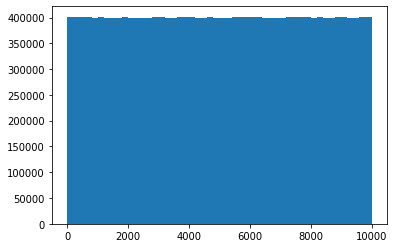

CPU times: total: 32.7 s
Wall time: 32.8 s


In [404]:
%time display(uniform_max = uniform_dist(10000, 2000000, True)) # ~35 seconds

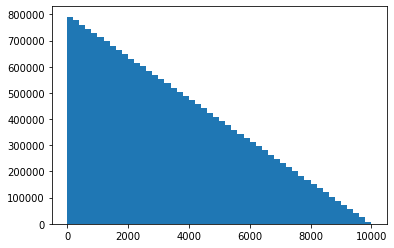

CPU times: total: 1min 11s
Wall time: 1min 12s


In [405]:
%time display(skewed_max = skewed_dist(10000, 2000000, True)) # ~70 seconds

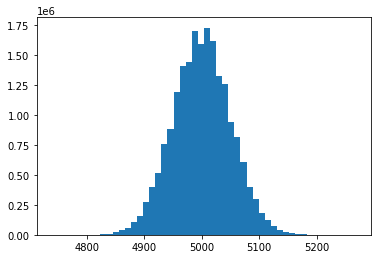

CPU times: total: 1min 37s
Wall time: 1min 37s


In [406]:
%time display(bino_max = binomial_dist(10000, 2000000, True)) # ~140 seconds

In [238]:
%time display(complete_max = complete(10000)) # ~10 seconds

CPU times: total: 10.6 s
Wall time: 10.6 s


In [239]:
%time display(cycle_max = cycle(10000)) # Instantaneous

CPU times: total: 0 ns
Wall time: 12 ms


### Input

* V = Number of vertices. (MAX = 10,000)
* E = Number of conflicts between pairs of vertices for random graphs. (MAX = 2,000,000)
* G = COMPLETE | CYCLE | RANDOM (with DIST below)
* DIST = UNIFORM | SKEWED | YOURS

### Output

* E[] = adjacency list of distinct course conflicts (length = 2M)
* P[] = Pointer for each course I, 1 <= I <= N denoting the starting point in E[] of the list of
courses in conflict with course I. 
  * That is, the conflicts for course I are indicated in locations E[P[I]], E[P[I]+1], …, E[P[I+1]-1].

### Procedure

The vertices for conflicts shall be chosen using a pseudo random number generator according to one of the specified distributions. These distributions are uniform, skewed, and one other of your choosing.<br/>
The uniform distribution assumes each vertex is equally likely to be chosen for a conflict. The skewed distribution assumes lower numbered vertices are linearly more likely than higher numbered vertices.<br/>
Graphs of these distributions are shown below. <br/><br/>
![Graph1](Probability-of-Choosing-Graphs.png)<br/>
**You may use a built-in uniform distribution pseudo-random number generator, but must base the
other distributions on the output of this built-in generator.**

In [10]:
def create_graph(V, E, G, DIST='', path='results.txt', debug=False):
    '''
    Creates graphs based on the input parameters.
    Writes the graph to the file in the format described above on the Output section.
    
    Parameters
    ----------
    V: int
        Number of vertices. (MAX = 10,000)
    E: int
        Number of conflicts between pairs of vertices for random graphs. (MAX = 2,000,000)
    G: string
        COMPLETE || CYCLE || RANDOM (with DIST below)
    DIST: string
        UNIFORM || SKEWED || BINOMIAL
    '''
    
    if G == 'COMPLETE':
        graph = complete(V)
    elif G == 'CYCLE':
        graph = cycle(V)
    else: # G == 'RANDOM'
        if ((V*(V-1))/2) < E:
            graph = complete(V)
        elif DIST == 'UNIFORM':
            graph = uniform_dist(V, E)
        elif DIST == 'SKEWED':
            graph = skewed_dist(V, E, debug=debug)
        else: # DIST == 'BINOMIAL'
            graph = binomial_dist(V, E)
    
    write_file(graph, path)

## Part 2

### Input: A file like the output in Part 1

* P[] = Pointer for each course I, 1 <= I <= N denoting the starting point in E[] of the list of
courses in conflict with course I.
  * That is, the conflicts for course I are indicated in locations E[P[I]], E[P[I]+1], …, E[P[I+1]-1].
* E[] = adjacency list of distinct course conflicts (length = 2M).

### Output

* For each vertex the color, original degree, (and degree when deleted for the smallest last ordering). These should be printed in the order colored.
* Total number of colors used, the average original degree, and the maximum “degree when deleted” value for the smallest last ordering, and the size of the terminal clique for the smallest last ordering.
* Any other summary data you wish to include.
* An output file of the format where each line is VERTEX_NUMBER, COLOR_NUMBER.

### Printing Functions

In [11]:
def print_adj(adj):
    '''
    Prints the adjacency list containing Vertex objects.

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    s = '['
    for i in range(len(adj)):
        s += '['
        for j in range(len(adj[i])):
            s += str(adj[i][j].id)
            if j != len(adj[i])-1:
                s += ', '
        s += ']'
        if i != len(adj)-1:
            s += ', \n'
    s+= ']'
    
    print(s)

In [12]:
def print_degrees(adj):
    '''
    Prints the adjacency list containing Vertex objects along with the degrees of each vertex.

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    s = '['
    for i in range(len(adj)):
        s += '['
        for j in range(len(adj[i])):
            s += str(adj[i][j].id) + ': ' + str(adj[i][j].degree)
            if j != len(adj[i])-1:
                s += ', '
        s += ']'
        if i != len(adj)-1:
            s += ', '
    s+= ']'
    
    print(s)

In [13]:
def print_dgl(adj):
    '''
    Prints the degree list.
    
    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    s = '['
    for i in range(len(adj)):
        s += '['
        for j in range(len(adj[i])):
            if type(adj[i][j]) == int:
                s += str(adj[i][j]) + ' Degrees: '
            else:
                s += str(adj[i][j].id)
            if j != len(adj[i])-1 and j != 0:
                s += ', '
        s += ']'
        if i != len(adj)-1:
            s += ', '
    s+= ']'
    print(s)

In [14]:
def print_graph_color(adj):
    '''
    Prints the the graph from adjacency list with colors.

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    G = nx.Graph()

    # Get Vertices from adj
    v_color = []
    for row in adj:
        G.add_node(row[0].id)
        v_color.append(row[0].color)

    # Add edges (from adjacency list) to graph
    for v in range(len(adj)):
        for e in range(len(adj[v])):
            if e != 0:
                G.add_edge(adj[v][0].id, adj[v][e].id)
    

    # Print the graph
    nx.draw_networkx(G, node_color=v_color, font_color='white')

In [15]:
def print_graph(adj):
    '''
    Prints the the graph from adjacency list without colors.
    
    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    G = nx.Graph()

    # Get total number of vertices
    v_num = len(adj)

    # Add Vertices to graph
    G.add_nodes_from(range(1, v_num+1))

    # Add edges (from adjacency list) to graph
    for v in range(len(adj)):
        for e in range(len(adj[v])):
            if e != 0:
                G.add_edge(adj[v][0].id, adj[v][e].id)

    # Print the graph
    nx.draw(G, with_labels=True, font_weight='bold')

### Helper Functions - Part 2

In [16]:
class Vertex:
    '''
    Vertex class. Instead of storing just an int in the adjacency list,
    we store a Vertex, which holds much more information.

    Parameters
    ----------
    id: int
        The value of the vertex
    adj_idx: int
        The row index of the vertex in the adjacency list. The column index is 0.
    degree: int
        The degree of the vertex. Calculated by the length of the list at the index of the vertex in the adjacency list
    idx_degree: tuple
        Optional parameter. The index of the vertex in the degree list. Will be filled in on get_degree_list(adj)
    color: int
        Optional parameter. The color of the vertex. Will be filled in on the coloring algorithms
    '''
    
    def __init__(self, id, adj_idx, degree, idx_degree=None, color=-1):
        self.id = id
        self.adj_idx = adj_idx
        self.degree = degree
        self.idx_degree = idx_degree
        self.color = color

In [17]:
def read_file(path='graph.txt', debug=False):
    '''
    Reads the file (created in Part 1) adnd returns the adjacency list filled with Vertex objects.

    Parameters
    ----------
    debug: bool
        Optional parameter. If true, prints the helpful statements.
        
    Returns
    -------
    adj: list of lists (Vertex objects)
        Adjacency list representing the graph
    '''
    
    file = open(path, 'r')
    num_lines = sum(1 for line in file)
    file.close()
    
    file = open(path, "r")
    
    # Adjacency list to be filled with Vertices
    adj = []
    edge_idxs = []
    
    # Get number of vertices
    num_vertices = int(file.readline())
    if debug: print('Number of Vertices: ', num_vertices)
    
    # Fill adjacency list with the vertices
    s = 'Edge Indexes: '
    for i in range(num_vertices):
        edge_idxs.append(int(file.readline()))
        if debug: s += (str(edge_idxs[i]) + ', ')
    edge_idxs.append(num_lines)
    if debug: s += str(edge_idxs[i+1])
    if debug: print(s)
    
    curr_line = num_vertices + 1
    nxt_line = edge_idxs[1]
    curr_edge_idx = 1
    if debug: print('Line after getting indexes: ', curr_line)
    if debug: print('Line for next index: ', nxt_line)
    
    # Fill adjacency list with the vertices
    for i in range(num_vertices):
        adj.append([Vertex(i+1, (i, 0), (edge_idxs[i+1]-edge_idxs[i]))])
        
    if debug: print('Just Vertices: ')
    if debug: print_vertices(adj)
    if debug: print('Degree Vertex 1: ', adj[0][0].degree)
    if debug: print('Degree Vertex 2: ', adj[1][0].degree)
    if debug: print('Degree Vertex 3: ', adj[2][0].degree)
    if debug: print('Degree Vertex 4: ', adj[3][0].degree)
    if debug: print('Degree Vertex 5: ', adj[4][0].degree)
    
    # Fill adjacency list with the edges
    curr_v = 0
    for i in range(num_vertices):
        for j in range(adj[i][0].degree):
            adj[i].append(adj[int(file.readline())-1][0])
        curr_v += 1
            
    if debug: print('Finished List: ')
    if debug: print_vertices(adj)
    
    file.close()
    return adj

In [18]:
def get_degree_list(adj, debug=False):
    '''
    Creates a degree list from the adjacency list.
    Updates the idx_degree, and deleted fields of the Vertex objects in both
    the degree and adjacency lists.
    
    Parameters
    ----------
    adj: list of lists (Vertex objects)
        The value of the vertex
    
    Returns
    -------
    edge_l: list of lists (Vertex objects and int (on first columns))
        First column of each row represents the number of degrees
        Other columns contain the Vertices with that degree
        eg: [0] -> [4]
            [1] -> [1, 2]
            [2] -> [3]
    '''
    
    high_deg = 0
    for i in adj:
        if high_deg <= i[0].degree:
            high_deg = i[0].degree
    if debug: print('High Degree: ', high_deg)
    
    edge_l = [[i] for i in range(high_deg+1)]
    
    for i in adj:
        i[0].idx_degree = (i[0].degree, len(edge_l[i[0].degree]))
        i[0].deleted = False
        edge_l[i[0].degree].append(i[0])
    
    if debug: print_degrees(edge_l)
    
    return edge_l

In [19]:
def remove_from_lists(adj, dgl, R):
    '''
    Removes the Vertex R from the Adjacency list and the Degree list. Also updates all
    attributes from the affected Vertices in both lists.
    
    Parameters
    ----------
    adj: list of lists (Vertex objects)
        The value of the vertex
    edge_l: list of lists (Vertex objects and int (on first columns))
        First column of each row represents the number of degrees
        Other columns contain the Vertices with that degree
    R: Vertex object
        The vertex to be removed
    '''
    
    connected = []
    # Find ID of Vertices connected to R
    for v in adj[R.adj_idx[0]]:
        if v.id != R.id:
            connected.append(v)
    
    # Remove R row from adjacency list
    del_row = adj[R.adj_idx[0]]
    adj.remove(del_row)
    
    # Update Adjacency List after R is removed
    for row in adj:
        # Rows after R are shifted down: Update indexes for greater Vertices
        if row[0].id > R.id:
            row[0].adj_idx = (row[0].adj_idx[0]-1, 0)
        
        # Remove any other instances of R
        for v in row:
            if v.id == R.id:
                row.remove(v)
        
        # Decrease degree of connected Vertices
        if row[0] in connected:
            row[0].degree -= 1
            
    
    # Remove R from degree list
    dgl[R.degree].remove(R)
        
    # Update degree list for connected nodes
    for v in connected:
        # Remove Vertex from previous
        dgl[v.degree+1].remove(v)
        
        # Update degree list index of Vertices in that row
        # Because they are shifted one to the left
        for vertex in dgl[v.degree+1]:
            # Skip over the first column because that represents the degree
            if type(vertex) != int:
                vertex.idx_degree = (vertex.idx_degree[0], vertex.idx_degree[1]-1)
    
    # Insert Vertices connected to R into the correct row in the degree list
    for v in connected:
        # Add Vertex to correct row
        dgl[v.degree].append(v)
        # Update its degree list index
        v.idx_degree = (v.degree, len(dgl[v.degree])-1)

In [20]:
def get_smallest_degree(dgl):
    '''
    Finds the first Vertex with the smallest degree using a Degree List.
    
    Parameters
    ----------
    degree_list: list of lists (Vertex objects)
        Degree list
    
    Returns
    -------
    small: Vertex object
        Vertex with the smallest degree on the graph
    '''
    
    # Go through Degree List
    for row in dgl:
        # Go over each row
        for v in row:
            # Skip over first column
            if type(v) != int:
                return v

In [21]:
def is_complete(adj):
    '''
    Checks if the adjancecy list passed is a complete graph.

    Parameters
    ----------
    adj: lists of lists (Vertex objects)
        Adjacency list representing a graph
        
    Returns
    -------
    bool
        True if the graph is complete, False otherwise
    '''
    for x in range(len(adj)):
        if len(adj) == len(adj[x]):
            return True
        else:
            return False

### Procedure

CS-7350 students are to use six different methods for ordering the vertices in the graph. One method all
students are to use is the smallest last ordering given below, another is the smallest original degree last
and the final one for all students is a uniform random ordering. The other orderings are of your own
choosing. Then you are to assign the minimum color to each vertex in the order determined by each
ordering so that it doesn’t conflict with the other vertices already colored. You will then report on the
following criteria for the different ordering methodologies:
* Asymptotic running time for Smallest Last Ordering and Coloring
* Total number of colors needed for each ordering for various graph types
* Report any other interesting metric for each ordering

### Smallest Last Vertex Ordering

ID:  4
   Original Degree 3
   Degree when Deleted:  0
ID:  1
   Original Degree 3
   Degree when Deleted:  1
ID:  3
   Original Degree 2
   Degree when Deleted:  2
ID:  5
   Original Degree 2
   Degree when Deleted:  1
ID:  2
   Original Degree 2
   Degree when Deleted:  2

Average Original Degree:  2.4
Terminal Clique Size:  3
Maximum Degree Deleted:  2
Total Colors:  3


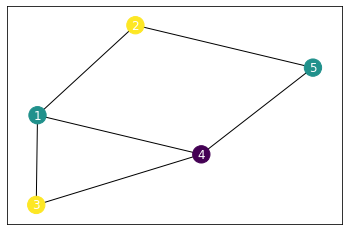

In [270]:
def small_v_ord(adj, dgl, path='results.txt', results=False):
    '''
    Colors the graph using the Smallest Vertex Ordering algorithm. 

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing a graph
    dgl: list of lists (Vertex objects and int (on first columns))
        Degree list
    path: str
        Optional. Path to file to save results to.
    results: bool
        Optional. Whether to print results to console.
        
    Returns
    -------
    total_colors: int
        Number of colors used
    c: list of lists (Vertex objects)
        Adjacency list representing the colored graph
    '''
    
    c = copy.deepcopy(adj)
    max_d_deleted = -1
    removed = []
    found = False
    total_colors = 0
    avg_orig = 0
    
    # Loop over all Vertices
    while len(adj) > 0:
        small_v = get_smallest_degree(dgl)
        avg_orig += c[small_v.id-1][0].degree
        
        # Get Max Degree when deleted
        if small_v.degree > max_d_deleted:
            max_d_deleted = small_v.degree
        
        removed.append(small_v)
        
        remove_from_lists(adj, dgl, small_v)
        
        # Check for Terminal Clique
        if not found:
            if is_complete(adj):
                terminal_clique = len(adj)
                found = True
    
    # Color graph
    for v in reversed(removed):
        if results:
            print('ID: ', v.id)
            print('   Original Degree', c[v.id-1][0].degree)
            print('   Degree when Deleted: ', v.degree)
        max_color = -1
        # Find max color in edges of v
        for vertex in c[v.id-1]:
            if c[vertex.id-1][0].color > max_color:
                max_color = c[vertex.id-1][0].color
        
        max_color += 1
        if max_color > total_colors:
            total_colors = max_color
        c[v.id-1][0].color = max_color
    
    if results:
        print()
        print('Average Original Degree: ', avg_orig / len(removed))
        print('Terminal Clique Size: ', terminal_clique)
        print('Maximum Degree Deleted: ', max_d_deleted)
        print('Total Colors: ', total_colors+1)
    
    file = open(path, 'w')
    for row in c:
        val = row[0].id, row[0].color
        s = str(val[0]) + ',' + str(val[1]) + '\n'
        file.write(s)
    file.close()
    
    return total_colors+1, c

handOut = [[1,2,3,4],[2,1,5],[3,1,4],[4,1,3,5],[5,2,4]]
write_file(handOut)
adj = read_file()
d = get_degree_list(adj)
colors, new = small_v_ord(adj, d, results=True)
print_graph_color(new)

The following format for the values of variables in various fields of the data node for each vertex may be used to save storage space. You may also split fields into different ones to avoid overloading a field for code readability and maintenance.<br/><br/>
![Table Example](Table-Example.png)<br/>
1. Establish the pointers to the lists of vertices of degree j, 0 <= j <= N-1, and any other pointers
or variables needed.
2. Create the code to iteratively delete a vertex of smallest degree, updating the third and
fourth fields of each data node to relate to the remaining graph, adding the vertex deleted
to the ordered list of vertices deleted.
3. After all vertices have been deleted, scan and assign colors (session periods) to each vertex
in an order opposite to the order deleted, assigning for a “color” the smallest non-negative
integer not previously assigned to any adjacent vertex. The output associated with each
vertex may be printed as the coloring is assigned.
4. Print any further output and summary information for the schedule.

For additional output with METHOD 1 you should include
* A graph indicating the degree when deleted on the vertical axes and the order colored on the x-axis.
* The maximum degree when deleted.
* The size of the terminal clique.
* Any other summary data you wish to include.

### Smallest Original Degree Last

The Smallest Original Degree Last method is a subset of the smallest last ordering. You should
determine the vertices to color based on their original degree, but not remove them from the
graph as you do it. This should run in THETA(V+E).

In [24]:
def get_v_by_degree(dgl):
    '''
    Orders the Verices in a degree list by their degree.

    Parameters
    ----------
    dgl: list of lists (Vertex objects and int (on first columns))
        Degree list
        
    Returns
    -------
    order: List of Vertex objects
        Ordered in increasing order by Vertex degree
    '''
    
    order = []
    
    # Go through Degree List
    for row in dgl:
        for v in row:
            if type(v) != int:
                order.append(v)
    
    return order

ID:  4
   Original Degree 3
ID:  1
   Original Degree 3
ID:  5
   Original Degree 2
ID:  3
   Original Degree 2
ID:  2
   Original Degree 2

Average Original Degree:  2.4
Total Colors:  3


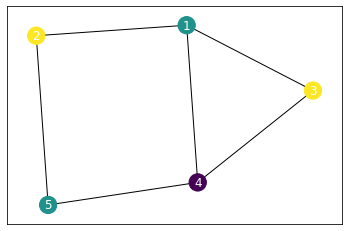

In [25]:
def small_orig(adj, dgl, path='results.txt', results=False):
    '''
    Colors the graph using the Smallest Original Degree Ordering algorithm.

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing a graph
    dgl: list of lists (Vertex objects and int (on first columns))
        Degree list
    path: str
        Optional. Path to file to save results to.
    results: bool
        Optional. Whether to print results to console.
        
    Returns
    -------
    total_colors: int
        Number of colors used
    '''
    
    total_colors = 0
    
    order = get_v_by_degree(dgl)
    order = reversed(order)
    avg_orig = 0
    
    for v in order:
        if results:
            print('ID: ', v.id)
            print('   Original Degree', adj[v.id-1][0].degree)
        avg_orig += v.degree
        max_color = -1
        # Find max color in edges of v
        for vertex in adj[v.id-1]:
            if adj[vertex.id-1][0].color > max_color:
                max_color = adj[vertex.id-1][0].color
        
        max_color += 1
        if max_color > total_colors:
            total_colors = max_color
        adj[v.id-1][0].color = max_color
    
    if results:
        print()
        print('Average Original Degree: ', avg_orig / len(adj))
        print('Total Colors: ', total_colors+1)
    
    file = open(path, 'w')
    for row in adj:
        val = row[0].id, row[0].color
        s = str(val[0]) + ',' + str(val[1]) + '\n'
        file.write(s)
    file.close()
    
    return total_colors+1

# * For each vertex the color, original degree. These should be printed in the order colored.
# * Total number of colors used, the average original degree.
# * Any other summary data you wish to include.
# * An output file of the format where each line is VERTEX_NUMBER, COLOR_NUMBER.

write_file(handOut)
adj = read_file()
d = get_degree_list(adj)
small_orig(adj, d, results=True)
print_graph_color(adj)

### Random Ordering

ID:  2
   Original Degree 2
ID:  5
   Original Degree 2
ID:  4
   Original Degree 3
ID:  1
   Original Degree 3
ID:  3
   Original Degree 2

Average Original Degree:  2.4
Total Colors:  5


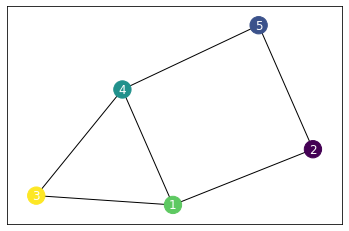

In [150]:
def random_coloring(adj, path="results.txt",results=False):
    '''
    Colors the graph by randomly coloring Vertices.

    Parameters
    ----------
    adj: list of lists (Vertex objects)
        Adjacency list representing a graph
    dgl: list of lists (Vertex objects and int (on first columns))
        Degree list
    path: str
        Optional. Path to file to save results to.
    results: bool
        Optional. Whether to print results to console.
        
    Returns
    -------
    total_colors: int
        Number of colors used
    '''
    
    total_colors = 0
    avg_orig = 0
    
    # Create sorted list
    l = [i+1 for i in range(len(adj))]
    
    # Shuffle list
    random.shuffle(l)
    
    # Color Vertices in randomly sorted order
    for num in l:
        v = adj[num-1][0]
        avg_orig += v.degree
        if results:
            print('ID: ', v.id)
            print('   Original Degree', adj[v.id-1][0].degree)
        max_color = -1
        # Find max color in edges of v
        for vertex in adj[v.id-1]:
            if adj[vertex.id-1][0].color > max_color:
                max_color = adj[vertex.id-1][0].color
        
        max_color += 1
        if max_color > total_colors:
            total_colors = max_color
        adj[v.id-1][0].color = max_color
    
    if results:
        print()
        print('Average Original Degree: ', avg_orig / len(adj))
        print('Total Colors: ', total_colors+1)
    
    file = open(path, 'w')
    for row in adj:
        val = row[0].id, row[0].color
        s = str(val[0]) + ',' + str(val[1]) + '\n'
        file.write(s)
    file.close()
    
    return total_colors+1

# * For each vertex the color, original degree. These should be printed in the order colored.
# * Total number of colors used, the average original degree.
# * Any other summary data you wish to include.
# * An output file of the format where each line is VERTEX_NUMBER, COLOR_NUMBER.

adj = read_file()
d = get_degree_list(adj)
random_coloring(adj, results=True)
print_graph_color(adj)

### Random Graph Generation

In [134]:
# Graphs to Compare Efficiency
handOut = [[1,2,3,4],[2,1,5],[3,1,4],[4,1,3,5],[5,2,4]] # From Assignment 2
write_file(handOut, path='Input Files/handOut.txt')
cube = [[1, 2, 6, 8], [2, 1, 3, 5], [3, 2, 4, 8], [4, 3, 5, 7], [5, 2, 4, 6], [6, 1, 5, 7], [7, 4, 6, 8], [8, 1, 3, 7]]
write_file(cube, path='Input Files/Cube.txt')

In [200]:
#  ~2 seconds
# Complete Graphs
create_graph(100, 1000, 'COMPLETE', path='Input Files/complete1Read.txt')
create_graph(200, 2000, 'COMPLETE', path='Input Files/complete2Read.txt')
create_graph(300, 3000, 'COMPLETE', path='Input Files/complete3Read.txt')
create_graph(400, 4000, 'COMPLETE', path='Input Files/complete4Read.txt')
create_graph(500, 5000, 'COMPLETE', path='Input Files/complete5Read.txt')
create_graph(1000, 10000, 'COMPLETE', path='Input Files/complete6Read.txt')
# Cycle Graphs
create_graph(500, 1000, 'CYCLE', path='Input Files/cycle1Read.txt')
create_graph(600, 2000, 'CYCLE', path='Input Files/cycle2Read.txt')
create_graph(700, 3000, 'CYCLE', path='Input Files/cycle3Read.txt')
create_graph(800, 4000, 'CYCLE', path='Input Files/cycle4Read.txt')
create_graph(900, 5000, 'CYCLE', path='Input Files/cycle5Read.txt')
create_graph(1000, 10000, 'CYCLE', path='Input Files/cycle6Read.txt')
# Uniform Distribution Graphs
create_graph(5000, 1000, 'RANDOM', 'UNIFORM', path='Input Files/uniform1Read.txt')
create_graph(5000, 2000, 'RANDOM', 'UNIFORM', path='Input Files/uniform2Read.txt')
create_graph(5000, 3000, 'RANDOM', 'UNIFORM', path='Input Files/uniform3Read.txt')
create_graph(5000, 4000, 'RANDOM', 'UNIFORM', path='Input Files/uniform4Read.txt')
create_graph(5000, 5000, 'RANDOM', 'UNIFORM', path='Input Files/uniform5Read.txt')
create_graph(5000, 10000, 'RANDOM', 'UNIFORM', path='Input Files/uniform6Read.txt')
# Binomial Distribution Graphs
create_graph(5000, 1000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial1Read.txt')
create_graph(5000, 2000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial2Read.txt')
create_graph(5000, 3000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial3Read.txt')
create_graph(5000, 4000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial4Read.txt')
create_graph(5000, 5000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial5Read.txt')
create_graph(5000, 10000, 'RANDOM', 'BINOMIAL', path='Input Files/binomial6Read.txt')
# Skewed Distribution Graphs
create_graph(5000, 1000, 'RANDOM', 'SKEWED', path='Input Files/skewed1Read.txt')
create_graph(5000, 2000, 'RANDOM', 'SKEWED', path='Input Files/skewed2Read.txt')
create_graph(5000, 3000, 'RANDOM', 'SKEWED', path='Input Files/skewed3Read.txt')
create_graph(5000, 4000, 'RANDOM', 'SKEWED', path='Input Files/skewed4Read.txt')
create_graph(5000, 5000, 'RANDOM', 'SKEWED', path='Input Files/skewed5Read.txt')
create_graph(5000, 10000, 'RANDOM', 'SKEWED', path='Input Files/skewed6Read.txt')

### Time Collecting

#### Smallest Vertex Ordering

In [201]:
# Complete Graphs ~1 minute
com_svo_times = []
com_svo_colors = []

adj = read_file('Input Files/complete1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults1.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)
adj = read_file('Input Files/complete2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults2.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)
adj = read_file('Input Files/complete3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults3.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)
adj = read_file('Input Files/complete4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults4.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)
adj = read_file('Input Files/complete5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults5.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)
adj = read_file('Input Files/complete6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/completeSVOResults6.txt')
end = time.time()
com_svo_colors.append(colors)
com_svo_times.append(end - start)

In [202]:
# Cycle Graph
cyc_svo_times = []
cyc_svo_colors = []

adj = read_file('Input Files/cycle1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults1.txt')
end = time.time()
cyc_svo_times.append(end - start)
cyc_svo_colors.append(colors)
adj = read_file('Input Files/cycle2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults2.txt')
end = time.time()
cyc_svo_times.append(end - start)
cyc_svo_colors.append(colors)
adj = read_file('Input Files/cycle3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults3.txt')
end = time.time()
cyc_svo_colors.append(colors)
cyc_svo_times.append(end - start)
adj = read_file('Input Files/cycle4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults4.txt')
end = time.time()
cyc_svo_colors.append(colors)
cyc_svo_times.append(end - start)
adj = read_file('Input Files/cycle5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults5.txt')
end = time.time()
cyc_svo_colors.append(colors)
cyc_svo_times.append(end - start)
adj = read_file('Input Files/cycle6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/cycleSVOResults6.txt')
end = time.time()
cyc_svo_colors.append(colors)
cyc_svo_times.append(end - start)

In [203]:
# Uniform 1
uni_svo_times = []
uni_svo_colors = []

adj = read_file('Input Files/uniform1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform1SVOResults.txt')
end = time.time()
uni_svo_times.append(end - start)
uni_svo_colors.append(colors)
adj = read_file('Input Files/uniform2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform2SVOResults.txt')
end = time.time()
uni_svo_colors.append(colors)
uni_svo_times.append(end - start)
adj = read_file('Input Files/uniform3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform3SVOResults.txt')
end = time.time()
uni_svo_colors.append(colors)
uni_svo_times.append(end - start)
adj = read_file('Input Files/uniform4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform4SVOResults.txt')
end = time.time()
uni_svo_colors.append(colors)
uni_svo_times.append(end - start)
adj = read_file('Input Files/uniform5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform5SVOResults.txt')
end = time.time()
uni_svo_colors.append(colors)
uni_svo_times.append(end - start)
adj = read_file('Input Files/uniform6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/uniform6SVOResults.txt')
end = time.time()
uni_svo_colors.append(colors)
uni_svo_times.append(end - start)

In [204]:
# Skewed 
ske_svo_times = []
ske_svo_colors = []

adj = read_file('Input Files/skewed1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed1SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)
adj = read_file('Input Files/skewed2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed2SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)
adj = read_file('Input Files/skewed3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed3SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)
adj = read_file('Input Files/skewed4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed4SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)
adj = read_file('Input Files/skewed5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed5SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)
adj = read_file('Input Files/skewed6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/skewed6SVOResults.txt')
end = time.time()
ske_svo_colors.append(colors)
ske_svo_times.append(end - start)

In [205]:
# Binomial 1
bin_svo_times = []
bin_svo_colors = []

adj = read_file('Input Files/binomial1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial1SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)
adj = read_file('Input Files/binomial2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial2SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)
adj = read_file('Input Files/binomial3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial3SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)
adj = read_file('Input Files/binomial4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial4SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)
adj = read_file('Input Files/binomial5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial5SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)
adj = read_file('Input Files/binomial6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors, new = small_v_ord(adj, d, path='Output Files/Smallest Vertex/binomial6SVOResults.txt')
end = time.time()
bin_svo_colors.append(colors)
bin_svo_times.append(end - start)

#### Smallest Original Degree Last

In [206]:
# Complete Graphs
com_sod_times = []
com_sod_colors = []

adj = read_file('Input Files/complete1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults1.txt')
end = time.time()
com_sod_times.append(end - start)
com_sod_colors.append(colors)
adj = read_file('Input Files/complete2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults2.txt')
end = time.time()
com_sod_colors.append(colors)
com_sod_times.append(end - start)
adj = read_file('Input Files/complete3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults3.txt')
end = time.time()
com_sod_colors.append(colors)
com_sod_times.append(end - start)
adj = read_file('Input Files/complete4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults4.txt')
end = time.time()
com_sod_colors.append(colors)
com_sod_times.append(end - start)
adj = read_file('Input Files/complete5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults5.txt')
end = time.time()
com_sod_colors.append(colors)
com_sod_times.append(end - start)
adj = read_file('Input Files/complete6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/completeSODResults6.txt')
end = time.time()
com_sod_colors.append(colors)
com_sod_times.append(end - start)

In [207]:
# Cycle Graphs
cyc_sod_times = []
cyc_sod_colors = []

adj = read_file('Input Files/cycle1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults1.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)
adj = read_file('Input Files/cycle2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults2.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)
adj = read_file('Input Files/cycle3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults3.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)
adj = read_file('Input Files/cycle4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults4.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)
adj = read_file('Input Files/cycle5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults5.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)
adj = read_file('Input Files/cycle6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/cycleSODResults6.txt')
end = time.time()
cyc_sod_colors.append(colors)
cyc_sod_times.append(end - start)

In [208]:
# Uniform Distribution Graphs
uni_sod_times = []
uni_sod_colors = []

adj = read_file('Input Files/uniform1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults1.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)
adj = read_file('Input Files/uniform2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults2.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)
adj = read_file('Input Files/uniform3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults3.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)
adj = read_file('Input Files/uniform4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults4.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)
adj = read_file('Input Files/uniform5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults5.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)
adj = read_file('Input Files/uniform6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/uniformSODResults6.txt')
end = time.time()
uni_sod_colors.append(colors)
uni_sod_times.append(end - start)

In [209]:
# Skewed Distribution Graphs
ske_sod_times = []
ske_sod_colors = []

adj = read_file('Input Files/skewed1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults1.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)
adj = read_file('Input Files/skewed2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults2.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)
adj = read_file('Input Files/skewed3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults3.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)
adj = read_file('Input Files/skewed4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults4.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)
adj = read_file('Input Files/skewed5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults5.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)
adj = read_file('Input Files/skewed6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/skewedSODResults6.txt')
end = time.time()
ske_sod_colors.append(colors)
ske_sod_times.append(end - start)

In [210]:
# Binomial Distribution Graphs
bin_sod_times = []
bin_sod_colors = []

adj = read_file('Input Files/binomial1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults1.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)
adj = read_file('Input Files/binomial2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults2.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)
adj = read_file('Input Files/binomial3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults3.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)
adj = read_file('Input Files/binomial4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults4.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)
adj = read_file('Input Files/binomial5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults5.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)
adj = read_file('Input Files/binomial6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = small_orig(adj, d, path='Output Files/Smallest Original Degree/binomialSODResults6.txt')
end = time.time()
bin_sod_colors.append(colors)
bin_sod_times.append(end - start)

#### Random Ordering

In [211]:
# Complete Graphs
com_ran_times = []
com_ran_colors = []

adj = read_file('Input Files/complete1Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults1.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)
adj = read_file('Input Files/complete2Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults2.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)
adj = read_file('Input Files/complete3Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults3.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)
adj = read_file('Input Files/complete4Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults4.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)
adj = read_file('Input Files/complete5Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults5.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)
adj = read_file('Input Files/complete6Read.txt')
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/completeRANResults6.txt')
end = time.time()
com_ran_colors.append(colors)
com_ran_times.append(end - start)

In [212]:
# Cycle Graphs
cyc_ran_times = []
cyc_ran_colors = []

adj = read_file('Input Files/cycle1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults1.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)
adj = read_file('Input Files/cycle2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults2.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)
adj = read_file('Input Files/cycle3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults3.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)
adj = read_file('Input Files/cycle4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults4.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)
adj = read_file('Input Files/cycle5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults5.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)
adj = read_file('Input Files/cycle6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/cycleRANResults6.txt')
end = time.time()
cyc_ran_colors.append(colors)
cyc_ran_times.append(end - start)

In [213]:
# Uniform Graphs
uni_ran_times = []
uni_ran_colors = []

adj = read_file('Input Files/uniform1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults1.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)
adj = read_file('Input Files/uniform2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults2.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)
adj = read_file('Input Files/uniform3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults3.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)
adj = read_file('Input Files/uniform4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults4.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)
adj = read_file('Input Files/uniform5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults5.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)
adj = read_file('Input Files/uniform6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/uniformRANResults6.txt')
end = time.time()
uni_ran_colors.append(colors)
uni_ran_times.append(end - start)

In [214]:
# Skewed Graphs
ske_ran_times = []
ske_ran_colors = []

adj = read_file('Input Files/skewed1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults1.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)
adj = read_file('Input Files/skewed2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults2.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)
adj = read_file('Input Files/skewed3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults3.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)
adj = read_file('Input Files/skewed4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults4.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)
adj = read_file('Input Files/skewed5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults5.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)
adj = read_file('Input Files/skewed6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/skewedRANResults6.txt')
end = time.time()
ske_ran_colors.append(colors)
ske_ran_times.append(end - start)

In [215]:
# Binomial Graphs
bin_ran_times = []
bin_ran_colors = []

adj = read_file('Input Files/binomial1Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults1.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)
adj = read_file('Input Files/binomial2Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults2.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)
adj = read_file('Input Files/binomial3Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults3.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)
adj = read_file('Input Files/binomial4Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults4.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)
adj = read_file('Input Files/binomial5Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults5.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)
adj = read_file('Input Files/binomial6Read.txt')
d = get_degree_list(adj)
start = time.time()
colors = random_coloring(adj, path='Output Files/Random/binomialRANResults6.txt')
end = time.time()
bin_ran_colors.append(colors)
bin_ran_times.append(end - start)

#### Creating Tables

In [271]:
complete_table_time = pd.DataFrame({
   'n (Vertices)': [100, 200, 300, 400, 500, 1000],
   'Smallest Vertex Ordering Time (s)': com_svo_times,
   'Smallest Original Degree Time (s)': com_sod_times,
   'Random Ordering Coloring Time (s)': com_ran_times
   })
cycle_table_time = pd.DataFrame({
   'n (Vertices)': [500, 600, 700, 800, 900, 10000],
   'Smallest Vertex Ordering Time (s)': cyc_svo_times,
   'Smallest Original Degree Time (s)': cyc_sod_times,
   'Random Ordering Coloring Time (s)': cyc_ran_times
   })
uniform_table_time = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time (s)': uni_svo_times,
   'Smallest Original Degree Time (s)': uni_sod_times,
   'Random Ordering Coloring Time (s)': uni_ran_times
   })
skewed_table_time = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time (s)': ske_svo_times,
   'Smallest Original Degree Time (s)': ske_sod_times,
   'Random Ordering Coloring Time (s)': ske_ran_times
   })
binomial_table_time = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time (s)': bin_svo_times,
   'Smallest Original Degree Time (s)': bin_sod_times,
   'Random Ordering Coloring Time (s)': bin_ran_times
   })
complete_table_colors = pd.DataFrame({
   'n (Vertices)': [100, 200, 300, 400, 500, 1000],
   'Smallest Vertex Ordering': com_svo_colors,
   'Smallest Original Degree': com_sod_colors,
   'Random Ordering Coloring': com_ran_colors
   })
cycle_table_colors = pd.DataFrame({
   'n (Vertices)': [500, 600, 700, 800, 900, 10000],
   'Smallest Vertex Ordering Time': cyc_svo_colors,
   'Smallest Original Degree Time': cyc_sod_colors,
   'Random Ordering Coloring Time': cyc_ran_colors
   })
uniform_table_colors = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time': uni_svo_colors,
   'Smallest Original Degree Time': uni_sod_colors,
   'Random Ordering Coloring Time': uni_ran_colors
   })
skewed_table_colors = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time': ske_svo_colors,
   'Smallest Original Degree Time': ske_sod_colors,
   'Random Ordering Coloring Time': ske_ran_colors
   })
binomial_table_colors = pd.DataFrame({
   'n (Edges)': [1000, 2000, 3000, 4000, 5000, 10000],
   'Smallest Vertex Ordering Time': bin_svo_colors,
   'Smallest Original Degree Time': bin_sod_colors,
   'Random Ordering Coloring Time': bin_ran_colors
   })

### Time Tables

In [268]:
complete_table_time

,n (Vertices),Smallest Vertex Ordering Time (s),Smallest Original Degree Time (s),Random Ordering Coloring Time (s)
0,100,0.042075,0.002000,0.002000
1,200,0.317633,0.004999,0.004999
2,300,1.046804,0.008003,0.009015
3,400,2.469790,0.016896,0.014827
4,500,4.812141,0.024845,0.023000
5,1000,41.427482,0.131068,0.120928


In [269]:
cycle_table_time

,n (Vertices),Smallest Vertex Ordering Time (s),Smallest Original Degree Time (s),Random Ordering Coloring Time (s)
0,500,0.067265,0.002002,0.002003
1,600,0.088516,0.001997,0.002000
2,700,0.121954,0.002494,0.002002
3,800,0.158756,0.002004,0.002003
4,900,0.200398,0.002001,0.003001
5,10000,0.247162,0.002000,0.001965


In [246]:
uniform_table_time

,n (Edges),Smallest Vertex Ordering Time (s),Smallest Original Degree Time (s),Random Ordering Coloring Time (s)
0,1000,4.097182,0.011535,0.020551
1,2000,4.717398,0.010001,0.016405
2,3000,5.224622,0.012826,0.015423
3,4000,5.539976,0.010776,0.015501
4,5000,6.168771,0.012125,0.016711
5,10000,8.478079,0.013983,0.014957


In [248]:
skewed_table_time

,n (Edges),Smallest Vertex Ordering Time (s),Smallest Original Degree Time (s),Random Ordering Coloring Time (s)
0,1000,3.991252,0.011826,0.013999
1,2000,4.404670,0.013009,0.011671
2,3000,4.795392,0.011905,0.011887
3,4000,5.170641,0.011712,0.013000
4,5000,5.738873,0.012975,0.012879
5,10000,7.748073,0.016876,0.014756


In [249]:
binomial_table_time

,n (Edges),Smallest Vertex Ordering Time (s),Smallest Original Degree Time (s),Random Ordering Coloring Time (s)
0,1000,4.205514,0.011467,0.013999
1,2000,4.446592,0.010001,0.010999
2,3000,4.839922,0.011585,0.012015
3,4000,5.499043,0.010716,0.012819
4,5000,5.638925,0.010999,0.013859
5,10000,7.562565,0.010858,0.012774


### Comparing Efficiency

In [272]:
complete_table_colors

,n (Vertices),Smallest Vertex Ordering,Smallest Original Degree,Random Ordering Coloring
0,100,100,100,100
1,200,200,200,200
2,300,300,300,300
3,400,400,400,400
4,500,500,500,500
5,1000,1000,1000,1000


In [273]:
cycle_table_colors

,n (Vertices),Smallest Vertex Ordering Time,Smallest Original Degree Time,Random Ordering Coloring Time
0,500,251,500,6
1,600,301,600,5
2,700,351,700,6
3,800,401,800,6
4,900,451,900,7
5,10000,501,1000,5


In [274]:
uniform_table_colors

,n (Edges),Smallest Vertex Ordering Time,Smallest Original Degree Time,Random Ordering Coloring Time
0,1000,5,4,5
1,2000,13,6,5
2,3000,46,6,6
3,4000,51,7,9
4,5000,40,8,9
5,10000,117,15,15


In [275]:
skewed_table_colors

,n (Edges),Smallest Vertex Ordering Time,Smallest Original Degree Time,Random Ordering Coloring Time
0,1000,7,6,4
1,2000,31,7,6
2,3000,38,7,7
3,4000,36,9,10
4,5000,26,12,10
5,10000,81,18,15


In [276]:
binomial_table_colors

,n (Edges),Smallest Vertex Ordering Time,Smallest Original Degree Time,Random Ordering Coloring Time
0,1000,41,22,24
1,2000,62,41,35
2,3000,69,55,56
3,4000,88,71,71
4,5000,91,74,77
5,10000,117,118,121


### Visualization of Coloring Algorithms

#### Hand Out From Assignment 2

ID:  4
   Original Degree 3
   Degree when Deleted:  0
ID:  1
   Original Degree 3
   Degree when Deleted:  1
ID:  3
   Original Degree 2
   Degree when Deleted:  2
ID:  5
   Original Degree 2
   Degree when Deleted:  1
ID:  2
   Original Degree 2
   Degree when Deleted:  2

Average Original Degree:  2.4
Terminal Clique Size:  3
Maximum Degree Deleted:  2
Total Colors:  3


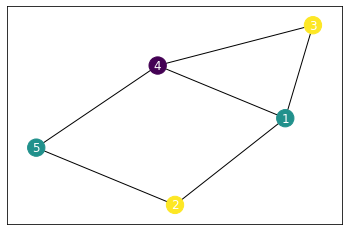

In [ ]:
# Smallest Vertex Ordering
adj = read_file('Input Files/handOut.txt')
d = get_degree_list(adj)
colors, new = small_v_ord(adj, d, results=True)
print_graph_color(new)

ID:  4
   Original Degree 3
ID:  1
   Original Degree 3
ID:  5
   Original Degree 2
ID:  3
   Original Degree 2
ID:  2
   Original Degree 2

Average Original Degree:  2.4
Total Colors:  3


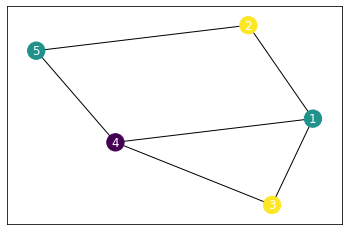

In [ ]:
# Smallest Original Degree Last

adj = read_file('Input Files/handOut.txt')
d = get_degree_list(adj)
colors = small_orig(adj, d, results=True)
print_graph_color(adj)

ID:  1
   Original Degree 3
ID:  5
   Original Degree 2
ID:  4
   Original Degree 3
ID:  2
   Original Degree 2
ID:  3
   Original Degree 2

Average Original Degree:  2.4
Total Colors:  3


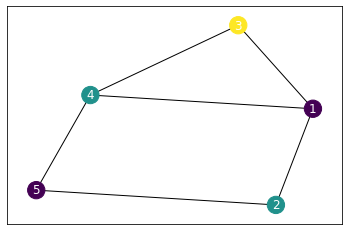

In [ ]:
# Random Ordering

adj = read_file('Input Files/handOut.txt')
d = get_degree_list(adj)
colors = random_coloring(adj, results=True)
print_graph_color(adj)

#### Graph Representing a Cube

ID:  4
   Original Degree 3
   Degree when Deleted:  0
ID:  7
   Original Degree 3
   Degree when Deleted:  1
ID:  3
   Original Degree 3
   Degree when Deleted:  1
ID:  8
   Original Degree 3
   Degree when Deleted:  2
ID:  5
   Original Degree 3
   Degree when Deleted:  1
ID:  6
   Original Degree 3
   Degree when Deleted:  2
ID:  2
   Original Degree 3
   Degree when Deleted:  2
ID:  1
   Original Degree 3
   Degree when Deleted:  3

Average Original Degree:  3.0
Terminal Clique Size:  2
Maximum Degree Deleted:  3
Total Colors:  4


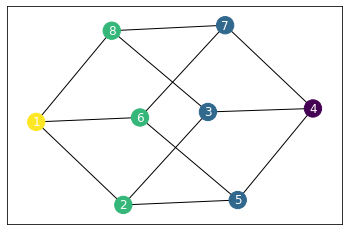

In [ ]:
# Smallest Vertex Ordering

adj = read_file('Input Files/Cube.txt')
d = get_degree_list(adj)
colors, new = small_v_ord(adj, d, results=True)
print_graph_color(new)

ID:  8
   Original Degree 3
ID:  7
   Original Degree 3
ID:  6
   Original Degree 3
ID:  5
   Original Degree 3
ID:  4
   Original Degree 3
ID:  3
   Original Degree 3
ID:  2
   Original Degree 3
ID:  1
   Original Degree 3

Average Original Degree:  3.0
Total Colors:  8


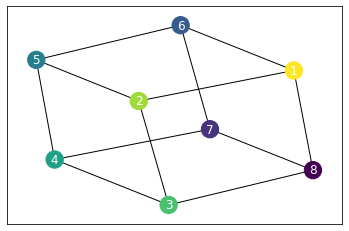

In [ ]:
# Smallest Original Degree Last

adj = read_file('Input Files/Cube.txt')
d = get_degree_list(adj)
colors = small_orig(adj, d, results=True)
print_graph_color(adj)

ID:  1
   Original Degree 3
ID:  7
   Original Degree 3
ID:  3
   Original Degree 3
ID:  8
   Original Degree 3
ID:  6
   Original Degree 3
ID:  4
   Original Degree 3
ID:  2
   Original Degree 3
ID:  5
   Original Degree 3

Average Original Degree:  3.0
Total Colors:  3


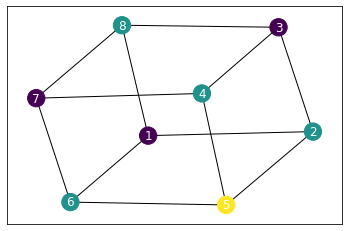

In [ ]:
# Random Ordering

adj = read_file('Input Files/Cube.txt')
d = get_degree_list(adj)
colors = random_coloring(adj, results=True)
print_graph_color(adj)

ID:  7
   Original Degree 3
ID:  3
   Original Degree 3
ID:  1
   Original Degree 3
ID:  5
   Original Degree 3
ID:  2
   Original Degree 3
ID:  4
   Original Degree 3
ID:  8
   Original Degree 3
ID:  6
   Original Degree 3

Average Original Degree:  3.0
Total Colors:  2


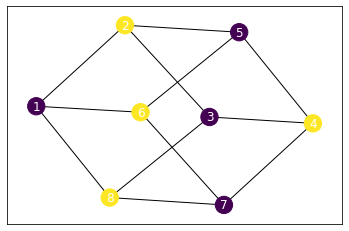

In [ ]:
# Random Ordering

adj = read_file('Input Files/Cube.txt')
d = get_degree_list(adj)
colors = random_coloring(adj, results=True)
print_graph_color(adj)

In [ ]:
# Smallest Vertex Ordering

avg_colors = 0
min_color = np.inf
max_color = -1
for i in range(100):
    adj = read_file('Input Files/Cube.txt')
    d = get_degree_list(adj)
    colors, new = small_v_ord(adj, d, results=False)
    if colors < min_color:
        min_color = colors
    if colors > max_color:
        max_color = colors
    avg_colors += colors
avg_colors /= 100
print('Average Colors: ', avg_colors)
print('Maximum Colors: ', max_color)
print('Minimum Colors: ', min_color)

Average Colors:  4.0
Maximum Colors:  4
Minimum Colors:  4


In [ ]:
# Smallest Original Degree Last

avg_colors = 0
min_color = np.inf
max_color = -1
for i in range(100):
    adj = read_file('Input Files/Cube.txt')
    d = get_degree_list(adj)
    colors = small_orig(adj, d, results=False)
    if colors < min_color:
        min_color = colors
    if colors > max_color:
        max_color = colors
    avg_colors += colors
avg_colors /= 100
print('Average Colors: ', avg_colors)
print('Maximum Colors: ', max_color)
print('Minimum Colors: ', min_color)

Average Colors:  8.0
Maximum Colors:  8
Minimum Colors:  8


In [ ]:
# Random Ordering

avg_colors = 0
min_color = np.inf
max_color = -1
for i in range(100):
    adj = read_file('Input Files/Cube.txt')
    d = get_degree_list(adj)
    colors = random_coloring(adj, results=False)
    if colors < min_color:
        min_color = colors
    if colors > max_color:
        max_color = colors
    avg_colors += colors
avg_colors /= 100
print('Average Colors: ', avg_colors)
print('Maximum Colors: ', max_color)
print('Minimum Colors: ', min_color)

Average Colors:  4.34
Maximum Colors:  8
Minimum Colors:  2
